In [1]:
%pip install aif360 pandas scikit-learn numpy

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install "aif360[all]"

  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
     ---------------------------------------- 0.0/2.6 MB ? eta -:--:--
     ---- ----------------------------------- 0.3/2.6 MB ? eta -:--:--
     ---- ----------------------------------- 0.3/2.6 MB ? eta -:--:--
     -------- ------------------------------- 0.5/2.6 MB 1.0 MB/s eta 0:00:02
     ------------ --------------------------- 0.8/2.6 MB 1.0 MB/s eta 0:00:02
     ---------------- ----------------------- 1.0/2.6 MB 1.0 MB/s eta 0:00:02
     -------------------- ------------------- 1.3/2.6 MB 1.1 MB/s eta 0:00:02
     ------------------------ --------------- 1.6/2.6 MB 1.0 MB/s eta 0:00:01
     ------------------------ --------------- 1.6/2.6 MB 1.0 MB/s e

In [6]:
import pandas as pd
import numpy as np
import json

from aif360.datasets import StandardDataset
from aif360.metrics import BinaryLabelDatasetMetric

In [7]:
df = pd.read_csv("data/master_airquality_clean.csv", low_memory=False)

df["Timestamp"] = pd.to_datetime(df["Timestamp"], errors="coerce")
df.dropna(subset=["Timestamp", "PM2.5"], inplace=True)

# Choose protected attribute (you can change)
df["hour"] = df["Timestamp"].dt.hour
df["dayofweek"] = df["Timestamp"].dt.dayofweek
df["is_weekend"] = (df["dayofweek"] >= 5).astype(int)  # 1 = weekend, 0 = weekday

df.head()

,Timestamp,PM2.5,PM10,O3,CO,Source,hour,dayofweek,is_weekend
0,2016-07-01 10:00:00,10.67,39.0,14.5,0.48,KaggleStation,10,4,0
1,2016-07-01 11:00:00,2.00,39.0,15.0,0.49,KaggleStation,11,4,0
2,2016-07-01 14:00:00,20.50,50.0,10.5,0.47,KaggleStation,14,4,0
3,2016-07-01 15:00:00,15.25,59.5,6.6,0.51,KaggleStation,15,4,0
4,2016-07-01 16:00:00,11.67,60.0,17.43,0.46,KaggleStation,16,4,0


In [10]:
# -----------------------------
# AIF360: Create Fairness Dataset (fixed)
# -----------------------------

df_fair = df.copy()

# Ensure protected attribute is numeric
df_fair["is_weekend"] = df_fair["is_weekend"].astype(int)

# Convert regression target to binary classification
median_value = df_fair["PM2.5"].median()
df_fair["label"] = (df_fair["PM2.5"] > median_value).astype(int)

# -------- FIX: REMOVE NON-NUMERIC COLUMNS --------
cols_to_drop = []

for col in df_fair.columns:
    if df_fair[col].dtype == 'object' or 'datetime' in str(df_fair[col].dtype):
        cols_to_drop.append(col)

print("Dropping columns (AIF360 incompatible):", cols_to_drop)

df_fair = df_fair.drop(columns=cols_to_drop)

# -------- FIX: REMOVE NaN rows --------
df_fair = df_fair.dropna()

# Protected attribute
protected_attribute = "is_weekend"

# Build dataset
dataset = StandardDataset(
    df=df_fair,
    label_name="label",
    favorable_classes=[0],
    protected_attribute_names=[protected_attribute],
    privileged_classes=[[0]]
)

dataset

Dropping columns (AIF360 incompatible): ['Timestamp', 'O3', 'CO', 'Source']


               instance weights features                         \
                                                                  
                                   PM2.5   PM10  hour dayofweek   
instance names                                                    
0                           1.0    10.67  39.00  10.0       4.0   
1                           1.0     2.00  39.00  11.0       4.0   
2                           1.0    20.50  50.00  14.0       4.0   
3                           1.0    15.25  59.50  15.0       4.0   
4                           1.0    11.67  60.00  16.0       4.0   
...                         ...      ...    ...   ...       ...   
12132839                    1.0    16.27  36.86   0.0       0.0   
12132840                    1.0    14.71  32.39   0.0       3.0   
12132841                    1.0     8.44  21.05   0.0       5.0   
12132842                    1.0     7.51  23.94   0.0       1.0   
12132843                    1.0    23.10  42.20   0.0       3.

In [11]:
metric = BinaryLabelDatasetMetric(
    dataset,
    privileged_groups=[{protected_attribute: 0}],
    unprivileged_groups=[{protected_attribute: 1}]
)

governance_report = {
    "protected_attribute": protected_attribute,
    "dataset_size": int(len(df)),
    "PM25_median_threshold": float(median_value),
    "mean_difference": float(metric.mean_difference()),
    "disparate_impact": float(metric.disparate_impact()),
    "statistical_parity_difference": float(metric.statistical_parity_difference()),
}

governance_report

{'protected_attribute': 'is_weekend',
 'dataset_size': 12129252,
 'PM25_median_threshold': 45.5,
 'mean_difference': 0.007535994985295114,
 'disparate_impact': 1.013303509747362,
 'statistical_parity_difference': 0.007535994985295114}

In [12]:
with open("governance_report.json", "w") as f:
    json.dump(governance_report, f, indent=4)

print("✔ governance_report.json saved!")

✔ governance_report.json saved!


In [13]:
import os
print("governance_report.json exists:", os.path.exists("governance_report.json"))

governance_report.json exists: True


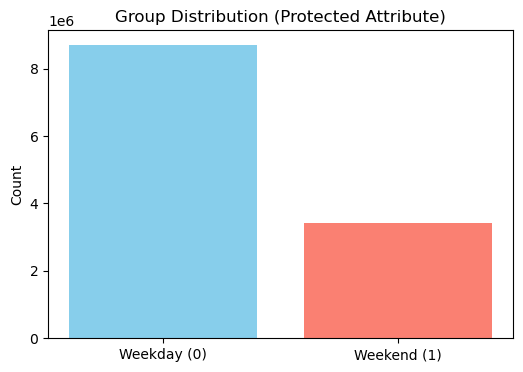

In [14]:
import matplotlib.pyplot as plt

group_counts = df_fair["is_weekend"].value_counts()
group_counts.index = ["Weekday (0)", "Weekend (1)"]

plt.figure(figsize=(6,4))
plt.bar(group_counts.index, group_counts.values, color=["skyblue", "salmon"])
plt.title("Group Distribution (Protected Attribute)")
plt.ylabel("Count")
plt.show()

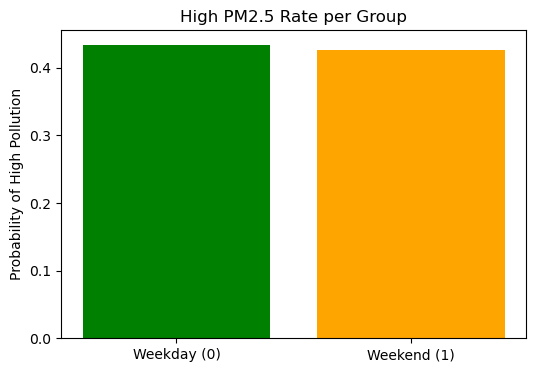

In [15]:
label_rates = df_fair.groupby("is_weekend")["label"].mean()
label_rates.index = ["Weekday (0)", "Weekend (1)"]

plt.figure(figsize=(6,4))
plt.bar(label_rates.index, label_rates.values, color=["green", "orange"])
plt.title("High PM2.5 Rate per Group")
plt.ylabel("Probability of High Pollution")
plt.show()

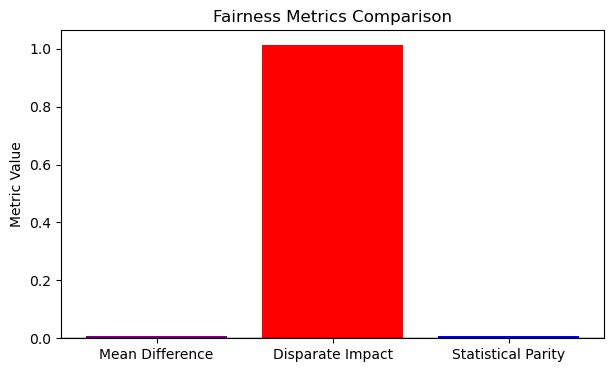

In [16]:
metrics = {
    "Mean Difference": governance_report["mean_difference"],
    "Disparate Impact": governance_report["disparate_impact"],
    "Statistical Parity": governance_report["statistical_parity_difference"]
}

plt.figure(figsize=(7,4))
plt.bar(metrics.keys(), metrics.values(), color=["purple", "red", "blue"])
plt.title("Fairness Metrics Comparison")
plt.ylabel("Metric Value")
plt.axhline(0, color="black", linewidth=1)
plt.show()